In [57]:
import os
import sys
import socket
import time
import numpy as np
import dask
from distributed import Client, LocalCluster
from dask.distributed import progress
import uproot
#import ROOT
from coffea.nanoevents import NanoEventsFactory, BaseSchema
from coffea.nanoevents.methods import vector
import awkward as ak
ak.behavior.update(vector.behavior)
from utils import choose, finalizePlotDir
import hist
import matplotlib.pyplot as plt
import mplhep as hep #matplotlib wrapper for easy plotting in HEP
plt.style.use(hep.style.CMS)

from utils import das_wrapper, redirectors, choose, delta_phi
'''
def get_muon1(events):
    return ak.zip({
        'pt': events['Muon1_pt'],
        'eta': events['Muon1_eta'],
        'phi': events['Muon1_phi'],
        'mass': events['Muon1_m'],
        'charge': events['Muon1_charge'],
        'dxy': events['Muon1_dxy'],
        'dz': events['Muon1_dz'],
        #'trackIso': events[f'{branch}trackIso'],
        }, with_name="PtEtaPhiMLorentzVector")
def get_muon2(events):
    return ak.zip({
        'pt': events['Muon2_pt'],
        'eta': events['Muon2_eta'],
        'phi': events['Muon2_phi'],
        'mass': events['Muon2_m'],
        'charge': events['Muon2_charge'],
        'dxy': events['Muon2_dxy'],
        'dz': events['Muon2_dz'],
        #'trackIso': events[f'{branch}trackIso'],
        }, with_name="PtEtaPhiMLorentzVector")
        
'''
def get_dimuon(events):
    return ak.zip({
        #'pt': events['dimuon_pt'],
        #'eta': events['dimuon_eta'],
        #'phi': events['dimuon_phi'],
        #'mass': events['dimuon_mass'],
        #'metphi': events['MET_phi'],
        #'metpt': events['MET_pt'],
        #'nmuon': events['nMuon'],
        'nmuonraw': events['nMuon_raw'],
        'ngenmuon': events['nGenMuon'],
        'genmuonpt': events['GenMuon_pt'],
        'genmuonphi': events['GenMuon_phi'],
        'genmuoneta': events['GenMuon_eta'],
        'genmuonm': events['GenMuon_m'],
        #'nDV': events['nDV'],
        #'nDV_raw': events['nDV_raw'],
        'genmuon_mother_idx': events['GenMuon_mother_idx'],
        'genmuon_grandmother_idx': events['GenMuon_grandmother_idx'],
        'genmuon_mother_m': events['GenMuon_mother_m'],
        'genmuon_grandmother_m': events['GenMuon_grandmother_m'],
        #'genpartpt': events['GenPart_pt'],
        #'genpartphi': events['GenPart_phi'],
        #'genparteta': events['GenPart_eta'],
        #'genpartm': events['GenPart_m'],
        #'genmuon_mothers_dR': events['GenMuon_mothers_dR']
        #'charge': events['Muon2_charge']
        #'trackIso': events[f'{branch}trackIso'],
        }, with_name="PtEtaPhiMLorentzVector")

def get_genparts(events):
    return ak.zip({
        #'pt': events['dimuon_pt'],
        #'eta': events['dimuon_eta'],
        #'phi': events['dimuon_phi'],
        #'mass': events['dimuon_mass'],
        #'metphi': events['MET_phi'],
        #'metpt': events['MET_pt'],
        #'nmuon': events['nMuon'],
        #'nmuonraw': events['nMuon_raw'],
        #'ngenmuon': events['nGenMuon'],
        #'genmuonpt': events['GenMuon_pt'],
        #'genmuonphi': events['GenMuon_phi'],
        #'genmuoneta': events['GenMuon_eta'],
        #'genmuonm': events['GenMuon_m'],
        #'nDV': events['nDV'],
        #'nDV_raw': events['nDV_raw'],
        #'genmuon_mother_idx': events['GenMuon_mother_idx'],
        #'genmuon_grandmother_idx': events['GenMuon_grandmother_idx'],
        #'genmuon_mother_m': events['GenMuon_mother_m'],
        #'genmuon_grandmother_m': events['GenMuon_grandmother_m'],
        'genpartpt': events['GenPart_pt'],
        'genpartphi': events['GenPart_phi'],
        'genparteta': events['GenPart_eta'],
        'genpartm': events['GenPart_m'],
        #'genmuon_mothers_dR': events['GenMuon_mothers_dR']
        #'charge': events['Muon2_charge']
        #'trackIso': events[f'{branch}trackIso'],
        }, with_name="PtEtaPhiMLorentzVector")

def plotter(event, var, histname, units, bins, binmin, binmax, leading = False, order = 1, counter = False):
    temp_axis = hist.axis.Regular(bins, binmin, binmax, name=f'{histname}', label=f'${units}$')
    temp_hist = hist.Hist(temp_axis)
    if leading == False:
        if event[var].layout.minmax_depth[1] > 1:
            temp_hist.fill(ak.flatten(event[var], axis =1))
        else:
            temp_hist.fill(ak.flatten(event[var], axis =0))
    else:
        b = ak.sort(event[var], ascending = False)
        temp = []
        for i in b:
            if len(i) < order:
                continue
            temp.append(i[order - 1])
        temp_hist.fill(temp)
    fig, ax = plt.subplots(figsize=(8, 8))
    #fig = plt.figure()
    temp_hist.plot1d(
        histtype="step",
        stack=False,
        #ax=ax,
    )
    
    if counter == True:
        count = len(ak.flatten(event[var]))
        plt.figtext(0.70, 0.80, f'N = {count}', dict(size=16))
    hep.cms.label("Preliminary",data=False,lumi='X',com=13,loc=0,ax=ax,fontsize=15,)
    fig.savefig(f'{plot_dir}/{histname}.png')
    plt.show()
    
def plotter_alt(dataset, histname, units, bins, binmin, binmax, leading = False, order = 1, counter = False):
    temp_axis = hist.axis.Regular(bins, binmin, binmax, name=f'{histname}', label=f'${units}$')
    temp_hist = hist.Hist(temp_axis)
    dataset = ak.Array(dataset)
    if leading == False:
        if dataset.layout.minmax_depth[1] > 1:
            temp_hist.fill(ak.flatten(dataset, axis =1))
        else:
            temp_hist.fill(ak.flatten(dataset, axis =0))
    else:
        b = ak.sort(dataset, ascending = False)
        temp = []
        for i in b:
            if len(i) < order:
                continue
            temp.append(i[order - 1])
        temp_hist.fill(temp)
    fig, ax = plt.subplots(figsize=(8, 8))
    #fig = plt.figure()
    temp_hist.plot1d(
        histtype="step",
        stack=False,
        #ax=ax,
    )
    
    if counter == True:
        count = len(ak.flatten(dataset))
        plt.figtext(0.70, 0.80, f'N = {count}', dict(size=16))
    hep.cms.label("Preliminary",data=False,lumi='X',com=13,loc=0,ax=ax,fontsize=15,)
    fig.savefig(f'{plot_dir}/{histname}.png')
    plt.show()
'''
    
def make_cartesian(pt, eta, phi, m):
    return [pt*np.cos(phi), pt*np.sin(phi), pt*np.sinh(eta), np.sqrt(pt**2 * (1 + np.sinh(eta)*np.sinh(eta)) + m**2)]
def make_cern(vec):
    pt = np.sqrt(vec[0]**2 + vec[1]**2)
    return [pt, np.arcsinh(vec[3] / pt), np.arctan(vec[1]/vec[0]), np.sqrt(vec[3]**2 - vec[2]**2 - vec[1]**2 - vec[0]**2)]

def mother_data(mother_events, genpart_list):
    for i in range(len(mother_events)):
        motherlist = []
        grandmotherlist = []
'''        
        


'\n    \ndef make_cartesian(pt, eta, phi, m):\n    return [pt*np.cos(phi), pt*np.sin(phi), pt*np.sinh(eta), np.sqrt(pt**2 * (1 + np.sinh(eta)*np.sinh(eta)) + m**2)]\ndef make_cern(vec):\n    pt = np.sqrt(vec[0]**2 + vec[1]**2)\n    return [pt, np.arcsinh(vec[3] / pt), np.arctan(vec[1]/vec[0]), np.sqrt(vec[3]**2 - vec[2]**2 - vec[1]**2 - vec[0]**2)]\n\ndef mother_data(mother_events, genpart_list):\n    for i in range(len(mother_events)):\n        motherlist = []\n        grandmotherlist = []\n'

In [11]:
'''
inFileName = '../../test.root'
with uproot.open(inFileName) as f:
    events = f["Events"]
    muons = events["Run3ScoutingMuons_hltScoutingMuonPacker__HLT./Run3ScoutingMuons_hltScoutingMuonPacker__HLT.obj"].arrays()
    muons4 = get_muons(muons)
    print(muons4)
'''
#inFile = ROOT.TFile.Open (inFileName," READ ")
#tree = inFile.Get("Events")

#for entryNum in range (0,tree.GetEntries ()):
#    tree.GetEntry (entryNum)

#tree.GetEntry(0)
#pt = getattr(tree, 'Run3ScoutingMuons_hltScoutingMuonPacker__HLT.obj')




'\ninFileName = \'../../test.root\'\nwith uproot.open(inFileName) as f:\n    events = f["Events"]\n    muons = events["Run3ScoutingMuons_hltScoutingMuonPacker__HLT./Run3ScoutingMuons_hltScoutingMuonPacker__HLT.obj"].arrays()\n    muons4 = get_muons(muons)\n    print(muons4)\n'

In [58]:
if __name__ == '__main__':

    plot_dir = os.path.expandvars('/home/users/$USER/public_html/run3_scouting_scenB')
    #finalizePlotDir(plot_dir)
    
    events = NanoEventsFactory.from_root(
        '../production/ScenBV1.root',
        schemaclass = BaseSchema,
       
        treepath='Events',
        entry_stop = 100000).events()
    #muon1        = get_muon1(events)
    #muon2        = get_muon2(events)
    dimuon       = get_dimuon(events)
    genparts     = get_genparts(events)
    #print(dimuon.genmuonpt.layout.minmax_depth[0])
        
   

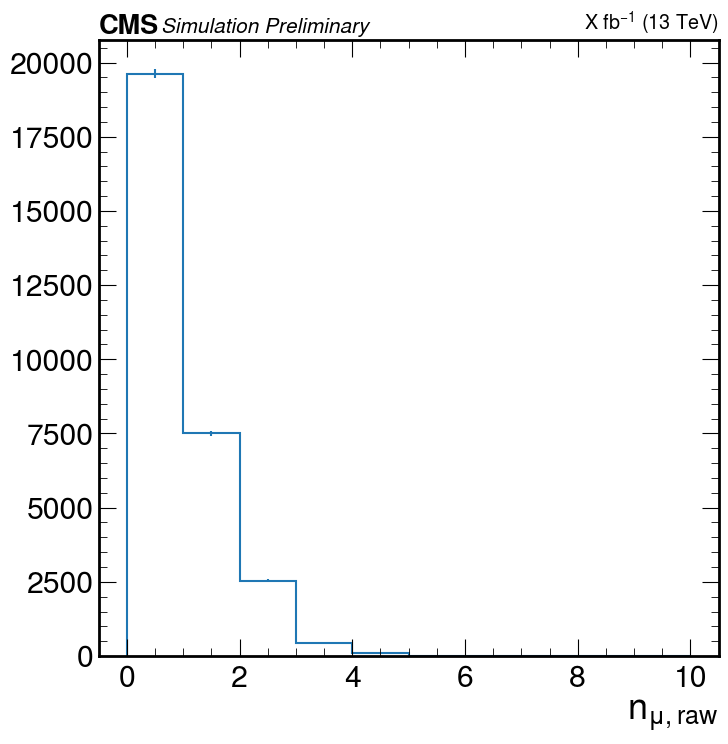

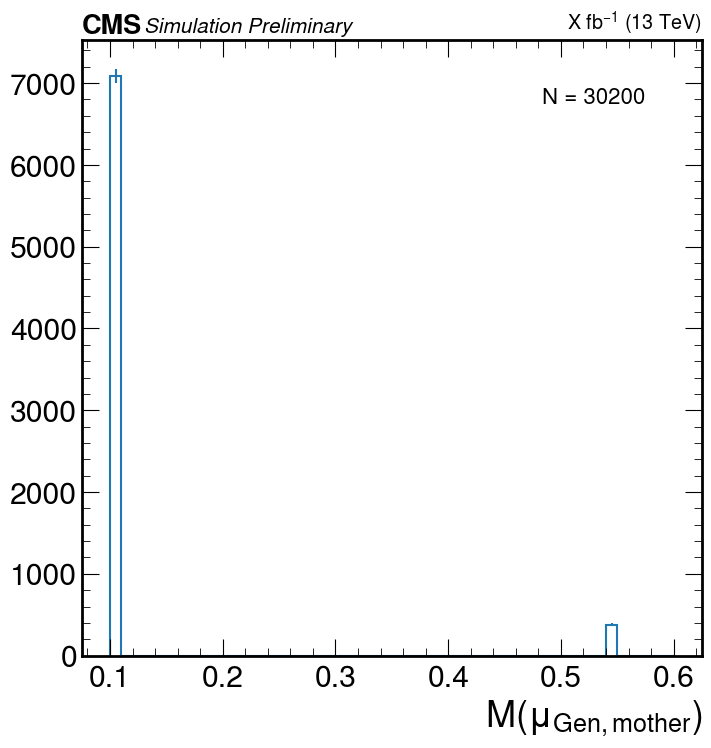

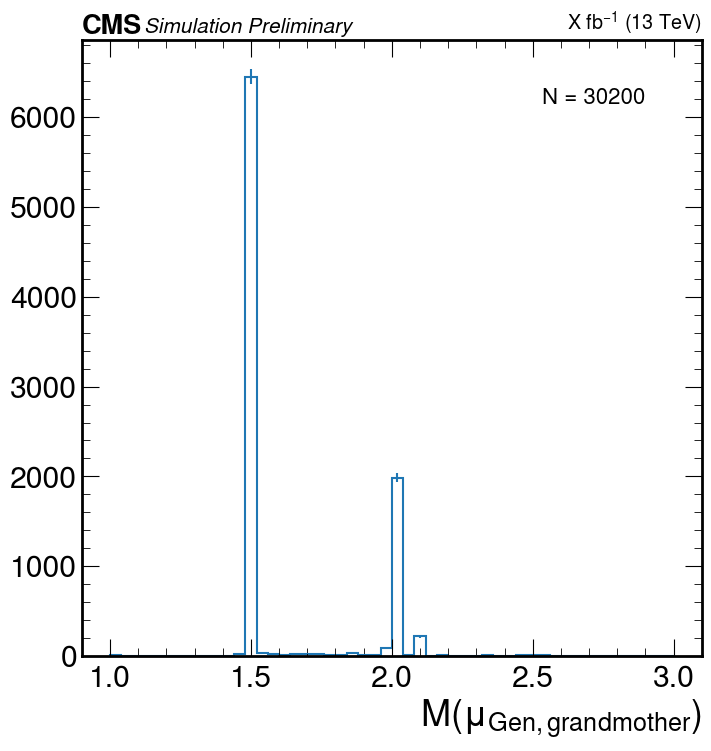

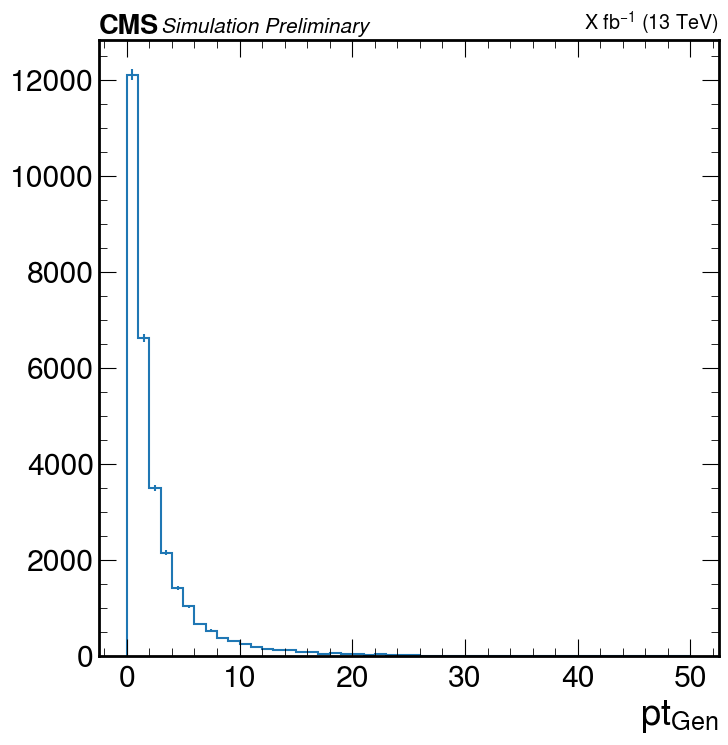

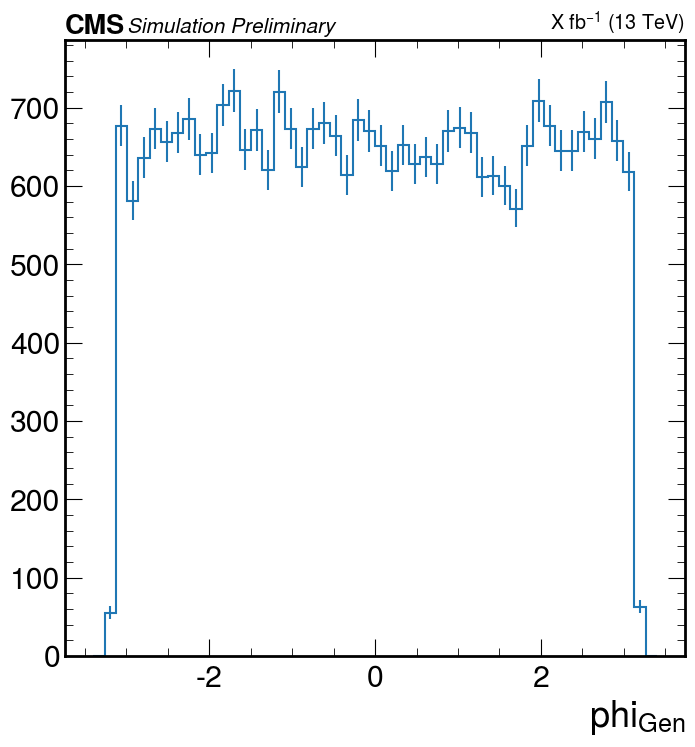

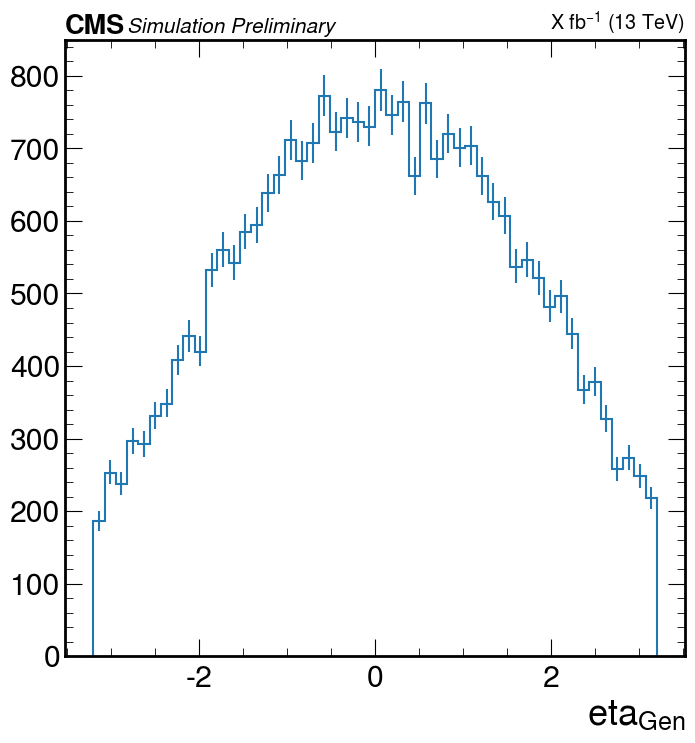

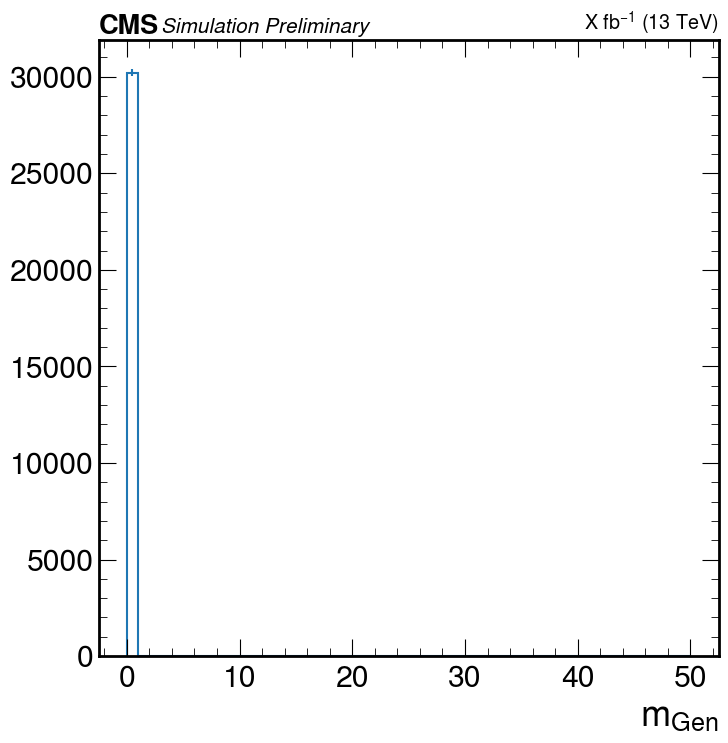

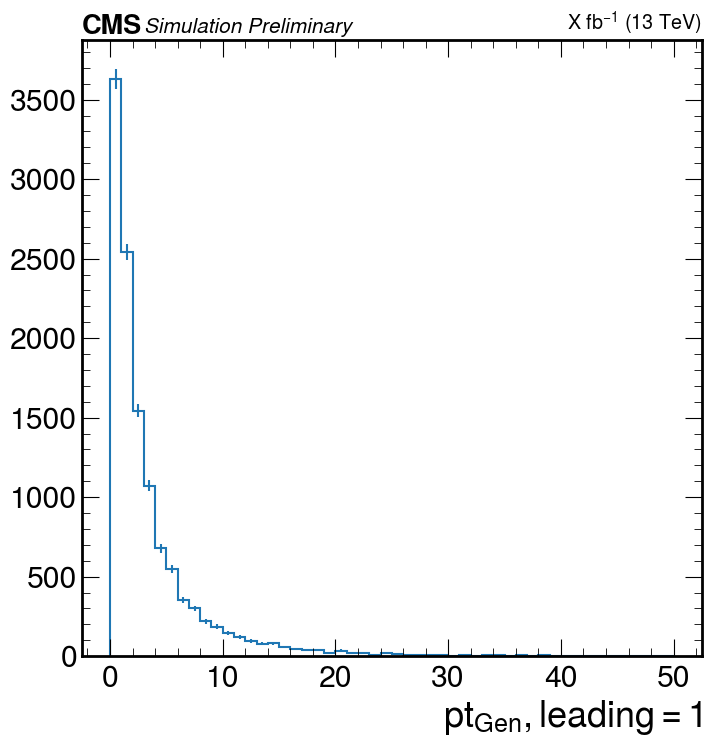

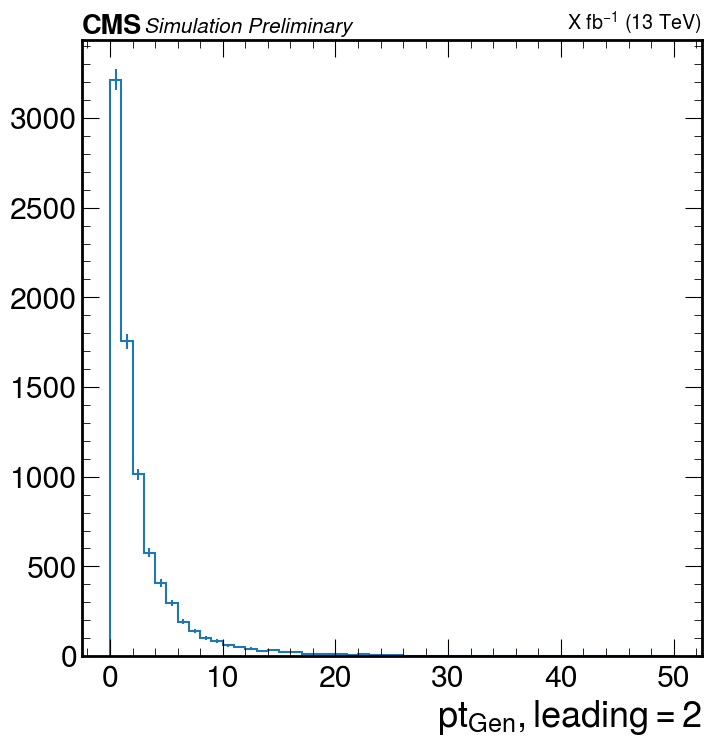

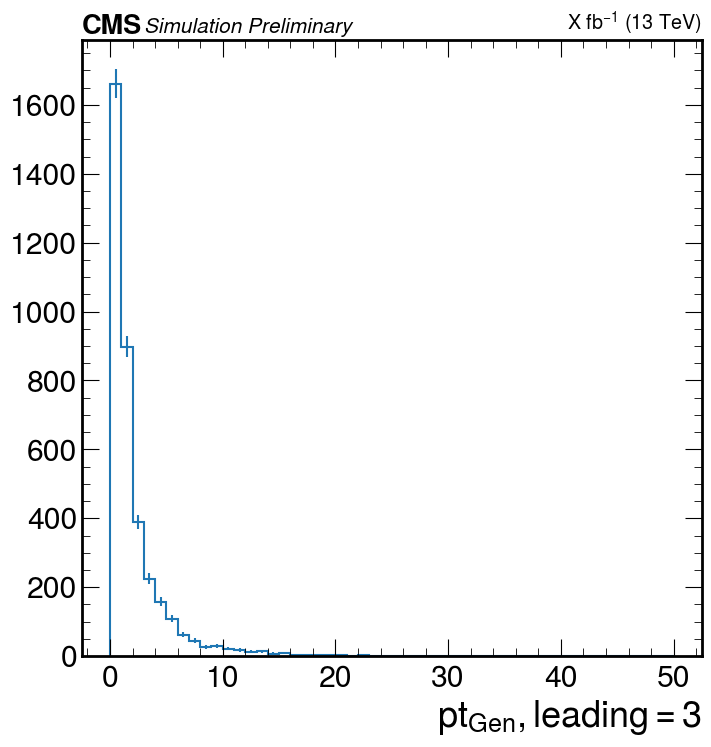

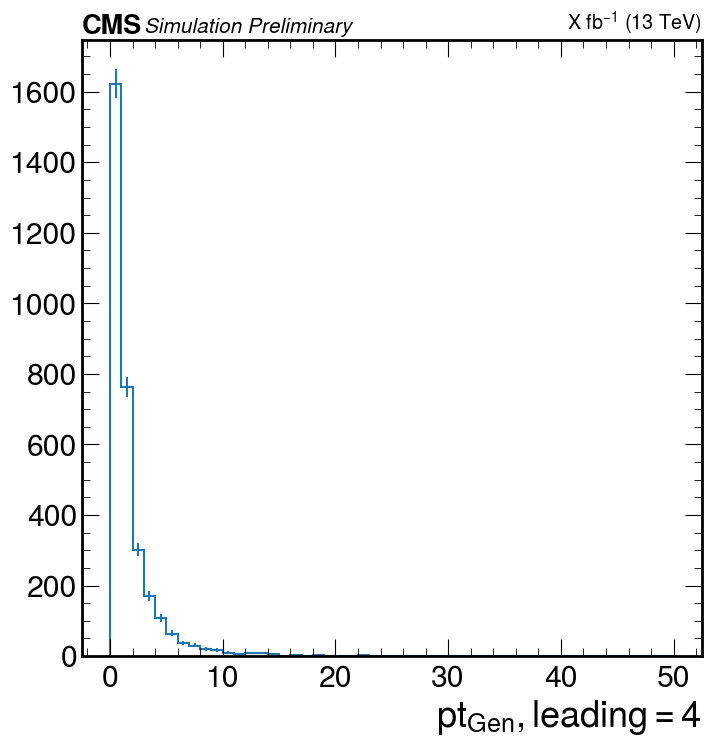

In [59]:
'''
plotter(event=muon1, var='pt', histname='Muon1_pt', units='pt(\mu_1)\ (GeV)',bins=20, binmin=0, binmax=50)
plotter(event=muon1, var='phi', histname='Muon1_phi', units='\phi(\mu_1)',bins=20, binmin=-3.4, binmax=3.4)
plotter(event=muon1, var='eta', histname='Muon1_eta', units='\eta(\mu_1)',bins=20, binmin=-3, binmax=3)
plotter(event=muon1, var='mass', histname='Muon1_mass', units='M(\mu_1) (GeV)',bins=20, binmin=0, binmax=50)
plotter(event=muon1, var='dxy', histname='Muon1_dxy', units='dxy(\mu_1)',bins=20, binmin=-50, binmax=50)
plotter(event=muon1, var='dz', histname='Muon1_dz', units='dz(\mu_1)',bins=20, binmin=-50, binmax=50)

plotter(event=muon2, var='pt', histname='Muon2_pt', units='pt(\mu_2)\ (GeV)',bins=20, binmin=0, binmax=50)
plotter(event=muon2, var='phi', histname='Muon2_phi', units='\phi(\mu_2)',bins=20, binmin=-3.4, binmax=3.4)
plotter(event=muon2, var='eta', histname='Muon2_eta', units='\eta(\mu_2)',bins=20, binmin=-3, binmax=3)
plotter(event=muon2, var='mass', histname='Muon2_mass', units='M(\mu_2) (GeV)',bins=20, binmin=0, binmax=50)
plotter(event=muon2, var='dxy', histname='Muon2_dxy', units='dxy(\mu_2)',bins=20, binmin=-50, binmax=50)
plotter(event=muon2, var='dz', histname='Muon2_dz', units='dz(\mu_2)',bins=20, binmin=-50, binmax=50)


'''
#plotter(event=dimuon, var='pt', histname='dimuon_pt', units='pt(\mu \mu)\ (GeV)',bins=20, binmin=0, binmax=50)
#plotter(event=dimuon, var='phi', histname='dimuon_phi', units='\phi(\mu \mu)',bins=20, binmin=-3.4, binmax=3.4)
#plotter(event=dimuon, var='eta', histname='dimuon_eta', units='\eta(\mu \mu)',bins=20, binmin=-3, binmax=3)
#plotter(event=dimuon, var='mass', histname='dimuon_mass', units='M(\mu \mu) (GeV)',bins=50, binmin=0, binmax=25)
#plotter(event=dimuon, var='nmuon', histname='nMuon', units='n_{\mu}',bins=10, binmin=0, binmax=10)
plotter(event=dimuon, var='nmuonraw', histname='nMuon_raw', units='n_{\mu, raw}',bins=10, binmin=0, binmax=10)
#plotter(event=dimuon, var='ngenmuon', histname='nGenMuon', units='N(\mu, Gen)',bins=20, binmin=0, binmax=20)
#plotter(event=dimuon, var='metphi', histname='MET_phi', units='\phi_{MET}',bins=20, binmin=-3.4, binmax=3.4)
#plotter(event=dimuon, var='metpt', histname='MET_pt', units='pt_{MET}',bins=100, binmin=0, binmax=800)
#plotter(event=dimuon, var='nDV', histname='nDV', units='nDV',bins=10, binmin=0, binmax=10)
#plotter(event=dimuon, var='nDV_raw', histname='nDV_raw', units='nDV_{raw}',bins=10, binmin=0, binmax=10)
plotter(event=dimuon, var='genmuon_mother_m', histname='GenMuon_mother_m', units='M(\mu_{Gen, mother})',bins=50, binmin=0.1, binmax=0.6, counter = True)
plotter(event=dimuon, var='genmuon_grandmother_m', histname='GenMuon_grandmother_m', units='M(\mu_{Gen, grandmother})',bins=50, binmin=1, binmax=3, counter = True)
#plotter(event=dimuon, var='genmuon_mothers_dR', histname='GenMuon_mothers_dR', units='dR(mother, grandmother)',bins=50, binmin=0, binmax=4)


plotter(event=dimuon, var='genmuonpt', histname='GenMuon_pt', units='pt_{Gen}',bins=50, binmin=0, binmax=50)
plotter(event=dimuon, var='genmuonphi', histname='GenMuon_phi', units='phi_{Gen}',bins=50, binmin=-3.4, binmax=3.4)
plotter(event=dimuon, var='genmuoneta', histname='GenMuon_eta', units='eta_{Gen}',bins=50, binmin=-3.2, binmax=3.2)
plotter(event=dimuon, var='genmuonm', histname='GenMuon_m', units='m_{Gen}',bins=50, binmin=0, binmax=50)
plotter(event=dimuon, var='genmuonpt', histname='GenMuon_pt_leading_1', units='pt_{Gen}, leading = 1',bins=50, binmin=0, binmax=50, leading = True, order = 1)
plotter(event=dimuon, var='genmuonpt', histname='GenMuon_pt_leading_2', units='pt_{Gen}, leading = 2',bins=50, binmin=0, binmax=50, leading = True, order = 2)
plotter(event=dimuon, var='genmuonpt', histname='GenMuon_pt_leading_3', units='pt_{Gen}, leading = 3',bins=50, binmin=0, binmax=50, leading = True, order = 3)
plotter(event=dimuon, var='genmuonpt', histname='GenMuon_pt_leading_4', units='pt_{Gen}, leading = 4',bins=50, binmin=0, binmax=50, leading = True, order = 4)

# Analysis Portion

In [60]:
mother_data = []
odd_muons = []
for i in range(len(dimuon['genmuon_mother_idx'])):
    if len(dimuon['genmuon_mother_idx'][i]) == 1: 
        odd_muons.append(dimuon['genmuon_mother_idx'][i][0])
        continue
    if len(dimuon['genmuon_mother_idx'][i]) == 0:
        continue
    for j in range(len(dimuon['genmuon_mother_idx'][i])):
        for k in range(len(dimuon['genmuon_mother_idx'][i])):
            if k != j and dimuon['genmuon_mother_idx'][i][k] == dimuon['genmuon_mother_idx'][i][j]:
                
                '''
                mu1p4 = np.array(make_cartesian(dimuon['genmuonpt'][i][j], dimuon['genmuoneta'][i][j], dimuon['genmuonphi'][i][j], dimuon['genmuonm'][i][j]))
                mu2p4 = np.array(make_cartesian(dimuon['genmuonpt'][i][k], dimuon['genmuoneta'][i][k], dimuon['genmuonphi'][i][k], dimuon['genmuonm'][i][k]))
                muonsys = mu1p4 + mu2p4
                '''
                muon12 = ak.zip({
                    'pt': ak.Array([dimuon['genmuonpt'][i][j], dimuon['genmuonpt'][i][k]]),
                    'eta': ak.Array([dimuon['genmuoneta'][i][j], dimuon['genmuoneta'][i][k]]),
                    'phi': ak.Array([dimuon['genmuonphi'][i][j], dimuon['genmuonphi'][i][k]]),
                    'mass': ak.Array([dimuon['genmuonm'][i][j], dimuon['genmuonm'][i][k]]),
                    }, with_name="PtEtaPhiMLorentzVector")
                muonsys = muon12[0]+ muon12[1]

                mother_idx = dimuon['genmuon_mother_idx'][i][j]
                grandmother_idx = dimuon['genmuon_grandmother_idx'][i][j]
                mother = ak.zip({
                    'pt': genparts['genpartpt'][i][mother_idx],
                    'eta': genparts['genparteta'][i][mother_idx],
                    'phi': genparts['genpartphi'][i][mother_idx],
                    'mass': genparts['genpartm'][i][mother_idx],
                    },  with_name="PtEtaPhiMLorentzVector")
                
                grandmother = ak.zip({
                    'pt': genparts['genpartpt'][i][grandmother_idx],
                    'eta': genparts['genparteta'][i][grandmother_idx],
                    'phi': genparts['genpartphi'][i][grandmother_idx],
                    'mass': genparts['genpartm'][i][grandmother_idx],
                    }, with_name="PtEtaPhiMLorentzVector")
                mother_data.append([muonsys, mother, grandmother])
            else: 
                odd_muons.append(dimuon['genmuon_mother_idx'][i][j])
                continue

#print(mother_data)

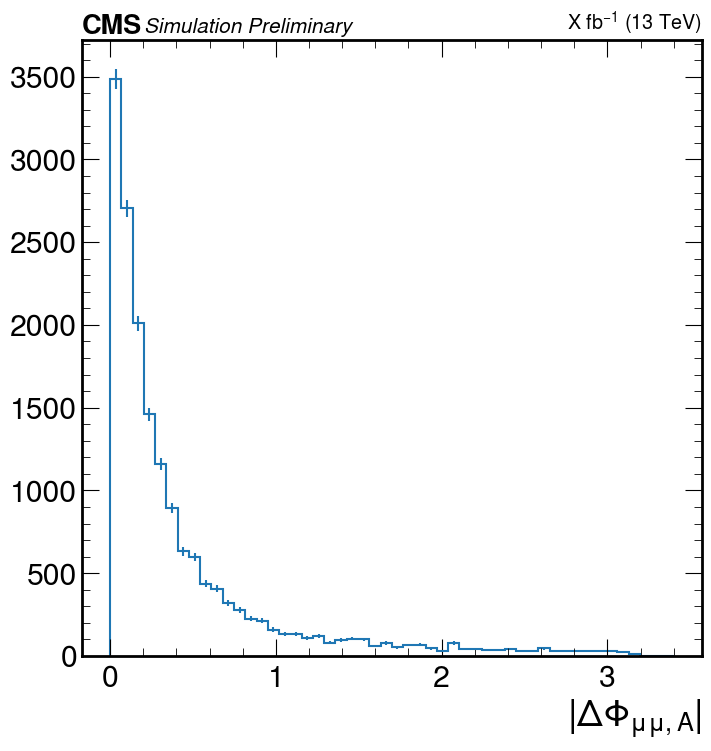

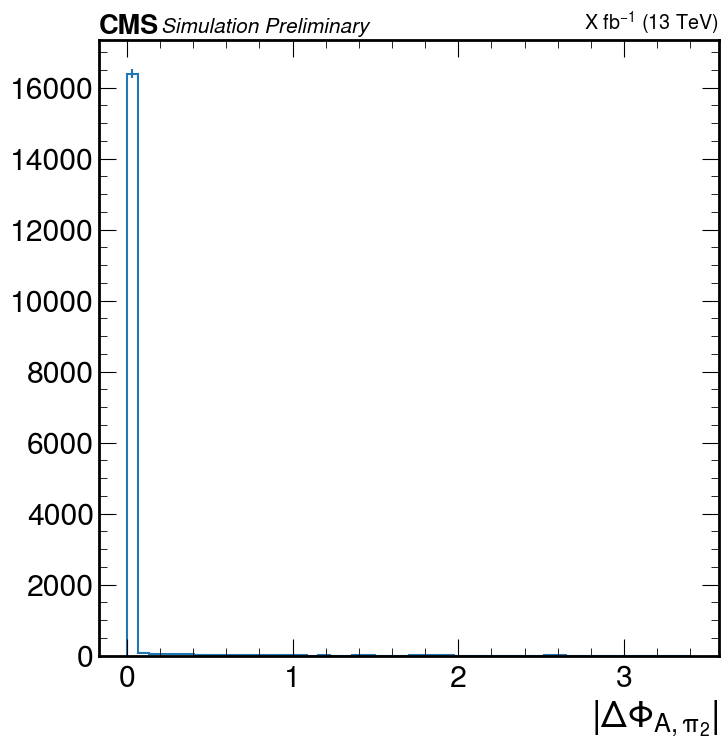

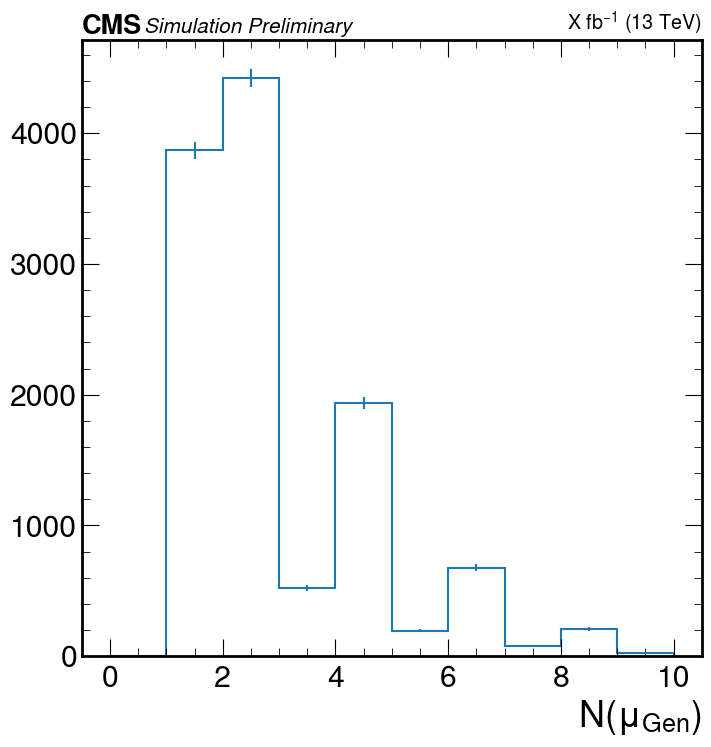

'\ntemp_axis = hist.axis.Regular(50, 0, 7, name=r\'muon_mother_phi\', label=r\'$| \\Delta\\Phi_{\\mu\\mu, A} |$\')\ntemp_hist = hist.Hist(temp_axis)\ntemp_hist.fill(np.abs(np.array(phi_diff)[:,1]))\nfig, ax = plt.subplots(figsize=(8, 8))\n#fig = plt.figure()\ntemp_hist.plot1d(\n    histtype="step",\n    stack=False,\n    #ax=ax,\n    )\nhep.cms.label("Preliminary",data=False,lumi=\'X\',com=13,loc=0,ax=ax,fontsize=15,)\nfig.savefig(f\'{plot_dir}/dPhi_2mu_A.png\')\n\ntemp_axis2 = hist.axis.Regular(50, 0, 7, name=r\'mother_grandmother_phi\', label=r\'$| \\Delta\\Phi_{A, \\pi_2} |$\')\ntemp_hist2 = hist.Hist(temp_axis2)\ntemp_hist2.fill(np.abs(np.array(phi_diff)[:,0]))\nfig, ax = plt.subplots(figsize=(8, 8))\n#fig = plt.figure()\ntemp_hist2.plot1d(\n    histtype="step",\n    stack=False,\n    #ax=ax,\n    )\nhep.cms.label("Preliminary",data=False,lumi=\'X\',com=13,loc=0,ax=ax,fontsize=15,)\nfig.savefig(f\'{plot_dir}/dPhi_A_pi2.png\')\n'

In [61]:
phi_diff = []
for i in mother_data:
    phi_diff.append([delta_phi(i[0], i[1]), delta_phi(i[1], i[2])])
#print(phi_diff)

plotter_alt(np.array(phi_diff)[:,1], histname='dPhi_2mu_A', units='| \Delta\Phi_{\mu\mu, A} |',bins=50, binmin=0, binmax=3.4)
plotter_alt(np.array(phi_diff)[:,0], histname='dPhi_A_pi2', units='| \Delta\Phi_{A, \pi_2} |',bins=50, binmin=0, binmax=3.4)
plotter_alt([x[0] for x in ak.to_list(dimuon['ngenmuon']) if len(x) != 0], histname='nGenMuon', units='N(\mu_{Gen})',bins=10, binmin=0, binmax=10)

'''
temp_axis = hist.axis.Regular(50, 0, 7, name=r'muon_mother_phi', label=r'$| \Delta\Phi_{\mu\mu, A} |$')
temp_hist = hist.Hist(temp_axis)
temp_hist.fill(np.abs(np.array(phi_diff)[:,1]))
fig, ax = plt.subplots(figsize=(8, 8))
#fig = plt.figure()
temp_hist.plot1d(
    histtype="step",
    stack=False,
    #ax=ax,
    )
hep.cms.label("Preliminary",data=False,lumi='X',com=13,loc=0,ax=ax,fontsize=15,)
fig.savefig(f'{plot_dir}/dPhi_2mu_A.png')

temp_axis2 = hist.axis.Regular(50, 0, 7, name=r'mother_grandmother_phi', label=r'$| \Delta\Phi_{A, \pi_2} |$')
temp_hist2 = hist.Hist(temp_axis2)
temp_hist2.fill(np.abs(np.array(phi_diff)[:,0]))
fig, ax = plt.subplots(figsize=(8, 8))
#fig = plt.figure()
temp_hist2.plot1d(
    histtype="step",
    stack=False,
    #ax=ax,
    )
hep.cms.label("Preliminary",data=False,lumi='X',com=13,loc=0,ax=ax,fontsize=15,)
fig.savefig(f'{plot_dir}/dPhi_A_pi2.png')
'''